# XGBoost Model

This is the XGBoost decision tree model.  

Accuracy score and metrics are below.  Kaggle Submission score is 0.78468

## Initialization

In [1]:
%run init.ipynb

In [2]:
from joblib import load, dump

model_filename = Path('../models/xgb.joblib').resolve()

In [3]:
import xgboost as xgb

from sklearn.preprocessing import scale

import great_expectations as ge

RANDOM_STATE = 42

from progressbar import ProgressBar
import seaborn as sns

from data.data import (transform_X_numerical, 
                           transform_X_categorical, 
                           transform_X)

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, cross_val_score, cross_validate


For more information on progressbar. Look here https://pypi.org/project/progressbar2/

## Extract Clean Data

**Separate data into X (features) and y (label) from the raw data**

This is exactly what Ben did in his notebook.

In [4]:
Xy = pd.read_csv('../data/processed/train__2019-11-21.csv', index_col='passengerid', dtype={'pclass':str})

**List of Features**

In [12]:
all_columns =['family_size', 'is_child', 'is_traveling_alone', 'sex_male',
       'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Officer', 'title_Royalty', 'age_bin_baby', 'age_bin_child',
       'age_bin_senior', 'age_bin_student', 'age_bin_teen',
       'age_bin_young_adult', 'fare_bin_q2', 'fare_bin_q3', 'fare_bin_q4',
       'pclass_2', 'pclass_3']

important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass']
important_features = ['title_Mr', 'pclass_2', 'pclass_3', 'family_size', 'fare', 'age']
#important_features = ['title_Mr',  'pclass_1', 'pclass_2', 'family_size',]

important_features = ['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 
                      'age_bin_baby', 'fare_bin_q4', 'age_bin_child', 'embarked_S', 'fare_bin_q2']

important_features = ['sex_male', 'title_Mr', 'pclass_3', 'title_Mrs', 'title_Miss', 'title_Officer', 'family_size', 
                      'age_bin_baby', 
                     ]
                      
important_features = ['is_child', 'fare_bin_q4', 'age_bin_baby',
                      'title_Miss', 'family_size', 'pclass_3',
                      'title_Mrs', 'title_Mr']

# important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass_2', 'pclass_3'] # This is the best score and model with the fewest features

#important_features = ['title_Mr', 'title_Mrs', 'family_size', 'is_child', 'pclass_2', 'pclass_3']
                    
#important_features = all_columns

model_features = important_features

In [13]:
X_all = transform_X(Xy.drop(['name', "age", "fare",], axis=1), 
                    numerical_columns=["family_size"],
    categorical_columns=[
        "sex",
        "embarked",
        "title",
        "age_bin",
        "fare_bin",
        "is_child",
        "is_traveling_alone",
        "pclass",
    ], )
X_all.columns = X_all.columns.str.replace(', ','_').str.replace(r'\[|\]|\(|\)','', regex=True)

X = X_all[model_features].copy()
X.describe()

y = Xy['survived']
X.shape

X.columns

,fare_bin_q4,age_bin_baby,title_Miss,family_size,pclass_3,title_Mrs,title_Mr
count,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000
mean,0.246914,0.053872,0.208754,-2.392400e-17,0.551066,0.143659,0.602694
std,0.431458,0.225892,0.406647,1.000562e+00,0.497665,0.350940,0.489615
min,0.000000,0.000000,0.000000,-5.609748e-01,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-5.609748e-01,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-5.609748e-01,1.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,5.915988e-02,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,5.640372e+00,1.000000,1.000000,1.000000


(891, 8)

Index(['is_child', 'fare_bin_q4', 'age_bin_baby', 'title_Miss', 'family_size',
       'pclass_3', 'title_Mrs', 'title_Mr'],
      dtype='object')

## Train Test Split Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

X_train.columns
X_train

Index(['is_child', 'fare_bin_q4', 'age_bin_baby', 'title_Miss', 'family_size',
       'pclass_3', 'title_Mrs', 'title_Mr'],
      dtype='object')

,is_child,fare_bin_q4,age_bin_baby,title_Miss,family_size,pclass_3,title_Mrs,title_Mr
passengerid,,,,,,,,
332,False,0,0,0,-0.560975,0,0,1
734,False,0,0,0,-0.560975,0,0,1
383,False,0,0,0,-0.560975,1,0,1
705,False,0,0,0,0.059160,1,0,1
814,True,0,0,1,3.159833,1,0,0
...,...,...,...,...,...,...,...,...
107,False,0,0,1,-0.560975,1,0,0
271,False,0,0,0,-0.560975,0,0,1
861,False,0,0,0,0.679295,1,0,1


In [26]:
y_test.to_frame()

,survived
passengerid,
710,1
440,0
841,0
721,1
40,1
...,...
434,0
774,0
26,1


In [27]:
X_test.to_csv('../data/processed/X_test__xgb.csv')
y_test.to_frame().to_csv('../data/processed/y_test__xgb.csv')

In [11]:
X_train.describe()
X_test.describe()

xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=1000, 
                          seed=123,
                          colsample_bytree=0.3, 
                          learning_rate=0.01, 
                          max_depth=3, 
                          max_features='sqrt',
                          random_state=RANDOM_STATE,
                          subsample=0.2)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)

,fare_bin_q4,age_bin_baby,title_Miss,family_size,pclass_3,title_Mrs,title_Mr
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.241573,0.057584,0.206461,0.017353,0.558989,0.137640,0.609551
std,0.428338,0.233119,0.405049,1.043392,0.496857,0.344764,0.488194
min,0.000000,0.000000,0.000000,-0.560975,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.560975,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-0.560975,1.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.059160,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,5.640372,1.000000,1.000000,1.000000


,fare_bin_q4,age_bin_baby,title_Miss,family_size,pclass_3,title_Mrs,title_Mr
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,0.268156,0.039106,0.217877,-0.069024,0.519553,0.167598,0.575419
std,0.444242,0.194391,0.413961,0.806888,0.501019,0.374556,0.495666
min,0.000000,0.000000,0.000000,-0.560975,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-0.560975,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-0.560975,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.059160,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,3.159833,1.000000,1.000000,1.000000


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.2, verbosity=1)

In [15]:
ii_y_pred, ii_predicted_accuracy_score, ii_cv_scores = pm.calc_model_rst_table_metrics(xg_cl, X_train, y_train, X_test, y_test, 
                                                      model_name='xgb', cv=5, verbose=True)
    


Accuracy Score on X_test,y_test:  0.8268


Cross Validation Scores:
	Accuracy 	: 0.8315 (+/- 0.0496)
	Recall		: 0.7163 (+/- 0.1259)
	Precision	: 0.8128 (+/- 0.0522)
	F1		: 0.7605 (+/- 0.0881)


12/04/19, xgb,  <kaggle_accuracy>, 0.8315, 0.7163,0.8128,0.7605


# Tuning the Model (Best LogReg Model Accuracy = 0.8384)

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [16]:
gbm_param_grid = {'learning_rate': [0.01],
                  'n_estimators': [250, 500, 750, 1000],
                  'subsample': [0.2, 0.3, 0.4, 0.5], 
                  'max_depth': [3,4,5,6],
                  'max_features': ['sqrt'],
                  'random_state': [RANDOM_STATE], 
                  'colsample_bytree':[0.2, 0.3, 0.4, 0.5]}

gsearch = GridSearchCV(estimator=xg_cl,
                       param_grid=gbm_param_grid,
                       scoring='accuracy', cv=4, verbose=1, n_jobs=4)


gsearch.fit(X, y)

print("\n\nBest parameters found: ",gsearch.best_params_)
print("Highest Accuracy: ", gsearch.best_score_)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 298 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 798 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:  1.1min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.3, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=1000, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_s...
                                     scale_pos_weight=1, seed=123, silent=None,
                                     subsample=0.2, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5],
                         'learning_rate': [0.01], 'max_depth': [3, 4, 5



Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.3}
Highest Accuracy:  0.8338945005611672


In [17]:
gsearch.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 1000,
 'random_state': 42,
 'subsample': 0.3}

**Save Model**

In [19]:
best_model = gsearch.best_estimator_
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.3, verbosity=1)

In [22]:
best_model.fit(X_train, y_train) 

dump(best_model, model_filename)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.3, verbosity=1)

['/Users/bkraft/projects/kaggle_titanic/models/xgb.joblib']

# Selecting Important Features

['is_child', 'fare_bin_q4', 'age_bin_baby', 'title_Miss', 'family_size', 'pclass_3', 'title_Mrs', 'title_Mr', 'sex_male']

Model Report
Accuracy : 0.8305
AUC Score (Train): 0.866589
CV Score : Mean - 0.8615983893557422 | Std - 0.04826591636927642 | Min - 0.7563025210084033 | Max - 0.9348739495798319


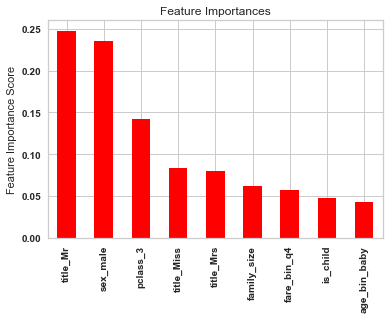

In [37]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=20):
    
    predictors = X.columns.tolist()
    print(predictors)
    
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    if performCV:
        print(f"CV Score : Mean - {np.mean(cv_score)} | Std - {np.std(cv_score)} | Min - {np.min(cv_score)} | Max - {np.max(cv_score)}")
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

modelfit(xg_cl, X, y)

# Simplify Model

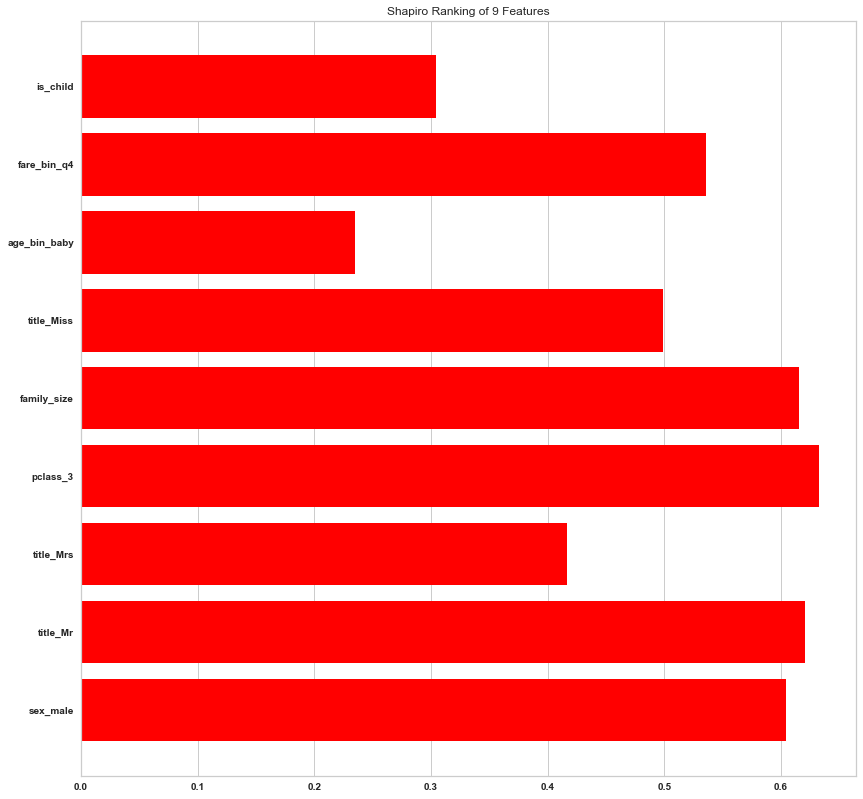

In [38]:
from yellowbrick.features import Rank1D

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', size=(1000,1000))

visualizer.fit(X, y, )           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show();          # Finalize and render the figure

https://www.districtdatalabs.com/visualize-data-science-pipeline-with-yellowbrick

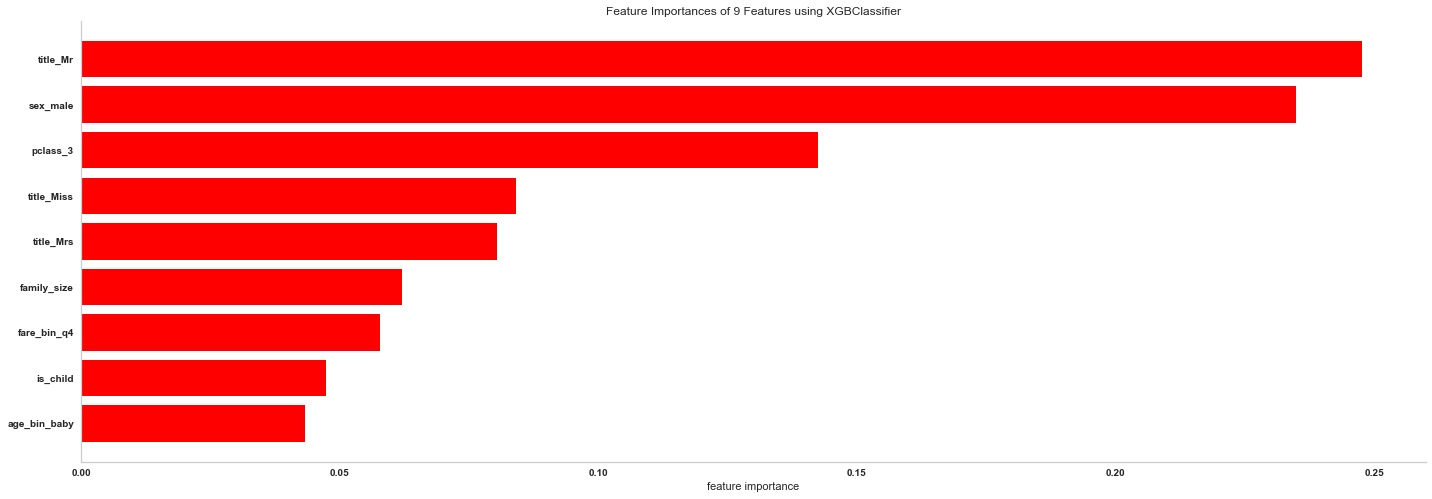

In [39]:
from cycler import cycler
import matplotlib as mpl
from yellowbrick.model_selection import FeatureImportances

model = xg_cl

# Create a new figure
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['red'])
fig = plt.gcf()
fig.set_size_inches(20,20)
ax = plt.subplot(311)
labels = X.columns

viz = FeatureImportances(model, ax=ax, labels=labels, relative=False, absolute=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

# Fit and display
viz.fit(X, y);
viz.poof();

In [40]:
viz.feature_importances_
viz.features_

array([0.04325945, 0.04737856, 0.0578504 , 0.06204736, 0.08044703,
       0.08411098, 0.14244196, 0.2349    , 0.24756424], dtype=float32)

array(['age_bin_baby', 'is_child', 'fare_bin_q4', 'family_size',
       'title_Mrs', 'title_Miss', 'pclass_3', 'sex_male', 'title_Mr'],
      dtype=object)

# Prepare Submission

In [62]:
model = gsearch.best_estimator_
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.3, verbosity=1)

In [63]:
from models import kaggle

filename = 'xgb.csv'

X_holdout = pd.read_csv('../data/processed/holdout__2019-11-21.csv', 
                        index_col='passengerid', 
                        dtype={'pclass':str, 'is_child':int, 'is_traveling_alone':int})

X_test_kaggle_public = transform_X(X_holdout).reindex(X_test.columns, axis=1)

X_test_kaggle_public.describe()

y_pred = (pd.Series(model.predict(X_test_kaggle_public), 
                   index=X_test_kaggle_public.index, name='Survived').to_frame().sort_index()
         )

y_pred.index.names = ['PassengerId']

y_pred.to_csv(filename)

message = (f'{filename} \n\n'
           f'This is a submission test via the Kaggle API. \n\n'
           f'{model} \n\n'
           f'{X_test_kaggle_public.columns} \n\n'
          )

print(message)

,is_child,fare_bin_q4,age_bin_baby,title_Miss,family_size,pclass_3,title_Mrs,title_Mr
count,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000,418.000000,418.000000
mean,0.069378,0.263158,0.038278,0.186603,-2.974760e-17,0.521531,0.177033,0.586124
std,0.254400,0.440875,0.192095,0.390059,1.001198e+00,0.500135,0.382154,0.493117
min,0.000000,0.000000,0.000000,0.000000,-5.534426e-01,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-5.534426e-01,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,-5.534426e-01,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,0.000000,1.056429e-01,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,6.037412e+00,1.000000,1.000000,1.000000


xgb.csv 

This is a submission test via the Kaggle API. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.3, verbosity=1) 

Index(['is_child', 'fare_bin_q4', 'age_bin_baby', 'title_Miss', 'family_size',
       'pclass_3', 'title_Mrs', 'title_Mr'],
      dtype='object') 




In [64]:
kaggle.submit_to_kaggle_titanic_competition(filename, message, upload=True);

xgb.csv
xgb.csv 

This is a submission test via the Kaggle API. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
              subsample=0.3, verbosity=1) 

Index(['is_child', 'fare_bin_q4', 'age_bin_baby', 'title_Miss', 'family_size',
       'pclass_3', 'title_Mrs', 'title_Mr'],
      dtype='object') 


b'Successfully submitted to Titanic: Machine Learning from Disaster'
b'\r  0%|          | 0.00/2.77k [00:00<?, ?B/s]\r100%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88| 2.77k/2.77k [00:00<00:00, 1